## Generate creds based on predictions

In [32]:
!pip install -q transformers torch numpy pandas matplotlib gdown seaborn


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
main_df = pd.read_csv("demo_datasets/main_demo.csv")

In [3]:
main_df["time_label"] = 0
main_df["food_label"] = 0
main_df["serv_label"] = 0
main_df["env_label"] = 0
total_num = main_df.shape[0]
total_num

10

In [4]:
main_df["aggregated_text"][0]

'I heard about Raising Cane\'s via Louisiana friends who sang praises of the joint. While in NOLA (and surrounding suburbs) my companions and I spotted several RCs and after driving around for sometime we decided to stop in to see what all the fuss was about.\n\nMenu: reminiscent of California\'s favorite burger joint, In-n-Out. The menu is basic and doesn\'t offer many options. If my memory serves me correctly you have 3-4 combos to choose from. The combo is dependent upon the  # of chicken strips you want. A combo includes fries, drink, coleslaw, Texas toast and chicken strips.\n\nCustomer service: We were greeted when we walked in and promptly addressed when our food was ready. My one complaint: the cashier asked if I wanted lemonade or a fountain drink for my drink choice and I chose lemonade. I saw the lemonade behind the counter but didn\'t think anything about it when she gave me my cup. I went to get my lemonade from the fountain and realized there wasn\'t any lemonade. I decid

In [5]:
class ReviewDatasetNoTarget(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

def create_main_data_loader_no_target(review_df, tokenizer, max_len, batch_size):
    ds = ReviewDatasetNoTarget(
        reviews= review_df,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [22]:
from transformers import DistilBertModel, DistilBertTokenizer

# Load the pre-trained model
model_name = "distilbert-base-uncased"
distilbert_model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() else 'cpu')
print(device)
distilbert_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


mps


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [23]:
from torch import nn

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.distilbert = DistilBertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.distilbert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.distilbert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = output.last_hidden_state[:, 0]
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
import gdown

time_model = SentimentClassifier(3)
food_model = SentimentClassifier(3)
env_model = SentimentClassifier(3)
serv_model = SentimentClassifier(3)

# Take shareable link from google drive
time_url = 'https://drive.google.com/file/d/1--RSVPrJ3nd_rRRysCDVrYoPTE_DMvQR/view?usp=sharing'
time_destination = 'machine_learning/models/v3/best_model_wait_time.bin'
gdown.download(time_url, time_destination, quiet=False,fuzzy=True)

food_url = 'https://drive.google.com/file/d/1-1NDuHhithta8QRAn8DUrAc9NjDwy-bZ/view?usp=sharing'
food_destination = 'machine_learning/models/v3/best_model_food_quality.bin'
gdown.download(food_url, food_destination, quiet=False,fuzzy=True)

env_url = 'https://drive.google.com/file/d/1-2tYpTLVKty2tCdiQ3FJzgrd54qwJ1_s/view?usp=sharing'
env_destination = 'machine_learning/models/v3/best_model_environment_quality.bin'
gdown.download(env_url, env_destination, quiet=False,fuzzy=True)

serv_url = 'https://drive.google.com/file/d/1-EIZTwVjfcnCiBqV55pGSXT-VfAPmozw/view?usp=sharing'
serv_destination = 'machine_learning/models/v3/best_model_service_quality.bin'
gdown.download(serv_url, serv_destination, quiet=False,fuzzy=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- T

In [25]:
time_model.load_state_dict(torch.load(time_destination, map_location=torch.device(device)))
food_model.load_state_dict(torch.load(food_destination, map_location=torch.device(device)))
env_model.load_state_dict(torch.load(env_destination, map_location=torch.device(device)))
serv_model.load_state_dict(torch.load(serv_destination, map_location=torch.device(device)))

time_model = time_model.to(device)
food_model = food_model.to(device)
env_model = env_model.to(device)
serv_model = serv_model.to(device)

In [26]:
BATCH_SIZE = 16
MAX_LEN = 512

test_models = [time_model, food_model, env_model, serv_model]

In [27]:
%%time
import warnings
warnings.filterwarnings('ignore')

for main_idx, review_string in enumerate(main_df["aggregated_text"]):
  result_df = [] if review_string == '' else review_string.split('|||')

  pred_data_loader = create_main_data_loader_no_target(
      result_df, tokenizer, MAX_LEN, BATCH_SIZE
      ) # change test_df to main
  label_columns = ['time_label', 'food_label', 'env_label', 'serv_label']

  result_df = pd.DataFrame(result_df, columns=['review'])
  for idx, model in enumerate(test_models):
      model_labels = []

      for d in pred_data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)

          model.eval()
          with torch.no_grad():
              outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask
              )
          _, preds = torch.max(outputs, dim=1)
          model_labels.extend(preds.cpu().numpy() - 1)

      result_df[label_columns[idx]] = model_labels
  for idx, model in enumerate(test_models):
    main_df[label_columns[idx]][main_idx] = result_df[label_columns[idx]].mean()


print("Finished processing")
main_df.to_csv('demo_datasets/mainCred_demo.csv', index=False)
print("Stored in mainCred_demo.csv")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Finished processing
Stored in mainCred_demo.csv
CPU times: user 9.61 s, sys: 11.1 s, total: 20.7 s
Wall time: 3min 11s


In [28]:
main_df.head()

,population,aggregated_text,review_count,restaurant_count,income,sum_check_in,time_label,food_label,serv_label,env_label
0,49497,I heard about Raising Cane's via Louisiana fri...,6,76,111491,2.31,0.000000,0.500000,0.166667,0.166667
1,120462,"Almost every time I order something, it comes ...",34,139,121166,34.02,-0.117647,-0.294118,-0.470588,0.029412
2,64269,"To the point, the sushi and service blows away...",101,49,183598,15.81,0.029703,0.881188,0.455446,0.277228
3,78624,Great food! My favorite is probably the butter...,17,83,76659,1.56,0.000000,0.294118,0.294118,0.058824
4,171258,Simply put.. Food is delicious and authentic t...,34,163,105296,103.44,0.029412,0.558824,-0.117647,0.000000


## Data Visualization

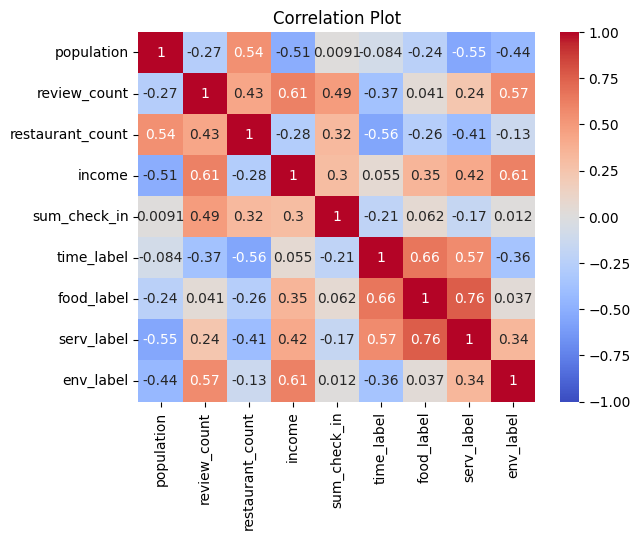

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the correlation matrix
corr_matrix = main_df.drop(columns=['aggregated_text']).corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.show()